# **Prototype Model Evaluation**

## **Step 0: Setup**

### **Step 0.1: Connect to Drive**

In [2]:
# Getting rid of _parent_header warning (slows colab)
import warnings

# Filter DeprecationWarnings whose text mentions Kernel._parent_header
warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=".*Kernel._parent_header is deprecated.*"
)

# Monkey-patch showwarning as a fallback (in case it's coming in from C-code)
_orig_showwarning = warnings.showwarning
def _silent_parent_header(message, category, filename, lineno, file=None, line=None):
    text = str(message)
    if category is DeprecationWarning and "Kernel._parent_header" in text:
        return
    _orig_showwarning(message, category, filename, lineno, file, line)

warnings.showwarning = _silent_parent_header

import os
os.environ["PYTHONWARNINGS"] = "ignore::DeprecationWarning"
import ipywidgets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import os

ROOT_DIR = "/content/drive/MyDrive/IE_421/agitrader"
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
print("CWD is now", os.getcwd())

CWD is now /content/drive/MyDrive/IE_421/agitrader


### **Step 0.2: Install Libraries**

Install the necessary libraries if you haven't already.

In [4]:
# Uncomment the following lines to

!pip install gymnasium[classic_control]
!pip install stable-baselines3==2.2.1
!pip install sb3-contrib==2.2.1
!pip install pandas numpy matplotlib tqdm tensorboard

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/build_env.py", line 21, in <module>
    from pip._internal.metadata import get_default_environment, get_environment
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/metadata/__init__.py", line 9, in <module>
    from .base import BaseDistribution, BaseEnvironment, FilesystemWheel, MemoryWheel, Wheel
  Fi

## **Step 1: Run Evaluation**

Change `features_path` to whatever the path to your data is.

Change `model_path` to the path of your model (this should be a .zip folder supported by SB3).

Change `max_eval_steps` to however many steps you want to evaluate.

Specify `metrics_out` and `logs_out` if you want a separate JSON and CSV file, respectively. The metrics JSON file will contain drawdown, PnL curve, and spread capture data. The CSV file is equivalent to the returned DataFrame.

**Tips:**
- If you want to perform a smoke test, reduce `max_eval_steps=1000` or some other small value for quick evaluation.
- You can ignore setting `max_eval_steps` if you want to evaluate the entire dataset (this may take a while).

### **What exactly does `evaluate` do under the hood?**
- Instantiates `LOBEnv`, loading features CSV and external reward function
- Loads PPO agent with given checkpoint or final model
- Loops `env.step()` and logs every field in `info` as well as the LSTM hidden states
- Returns two things
  - A DataFrame containing the evaluation info.
  - An array containing the hidden states.

In [10]:
from evaluation.evaluate import evaluate

features_path = "./data/splits/AAPL_20250407_train.csv"
model_path = "./models/final_model.zip"
max_eval_steps = 5000

df, hidden_array = evaluate(features_path=features_path, checkpoint_path=model_path, max_eval_steps=max_eval_steps)

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object _last_lstm_states. Consider using `custom_objects` argument to replace this object.
Exception: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
  warnings.warn(


Initialized TradingLSTMPolicy with LSTM size: 64


Evaluating: 100%|██████████| 5000/5000 [00:30<00:00, 164.02step/s]


## **Step 2: Visualize Evaluation**

- Once you have the returned DataFrame and hidden states array, you can call the plotting functions, passing the DataFrame as an argument. You can view more in-depth documentation for the plotting functions in `evaluation.ipynb`.

- If you desire to only plot the clustering for one method or another, you can change the `methods` list. Keep in mind the only supported methods (so far) are `rediscovery` and `novel`. To better tune the clustering, you can tinker with the values of `min_samples` and `min_cluster_size`.

- Comment/uncomment whichever plotting functions you want.

- Keep in mind the clustering algorithms may take a while.

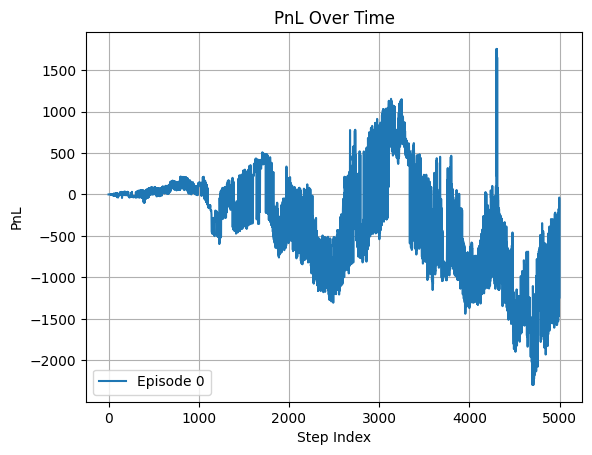

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


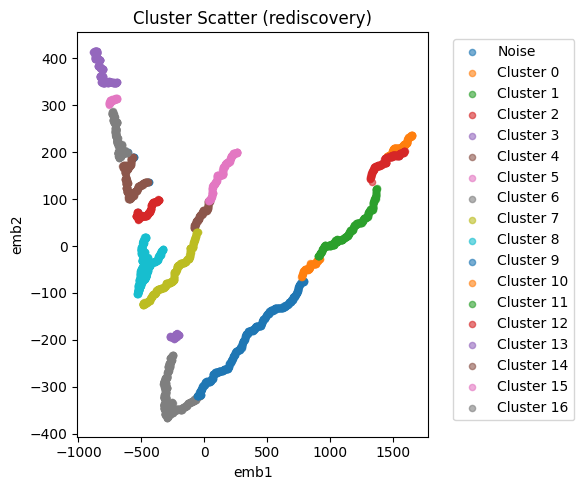

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


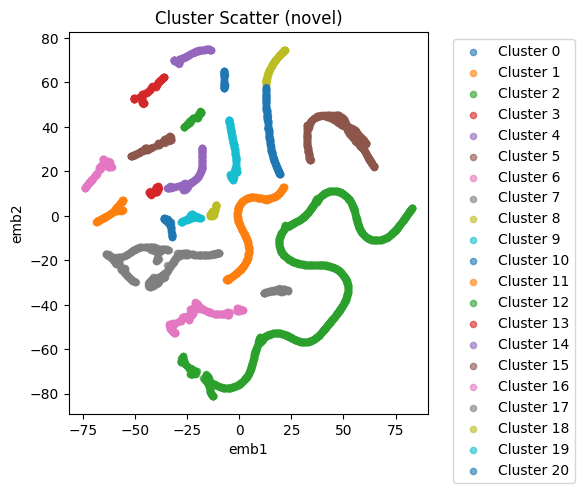

In [11]:
from evaluation.plot import (plot_cluster_scatter,
                             plot_reward_per_episode,
                             plot_pnl_over_time,
                             plot_action_frequency,
                             plot_inventory,
                             plot_risk_scatter,
                             plot_anomaly,
                             plot_profitability)

plot_pnl_over_time(df)

# plot_inventory(df)

# plot_risk_scatter(df)

# plot_anomaly(df)

# plot clusters for each method
methods = ["rediscovery", "novel"] # supported methods
min_samples = 20
min_cluster_size = 50

for method in methods:
    plot_cluster_scatter(df, hidden_array, method=method, min_cluster_size=min_cluster_size)